In [1]:
from vedo import *
import os
from ipyvtklink.viewer import ViewInteractiveWidget
import pykitti
import numpy as np
import tensorflow as tf
from tensorflow.math import sin, cos, tan
import tensorflow_probability as tfp
import pickle
import matplotlib.pyplot as plt


%load_ext autoreload
%autoreload 2
%autosave 180
%matplotlib notebook

C:\Users\Derm\anaconda3\envs\tf23\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Derm\anaconda3\envs\tf23\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\Derm\anaconda3\envs\tf23\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


Autosaving every 180 seconds


In [43]:
#load data
estimates = np.loadtxt("Ford_estimates_v4.txt")
pred_stds = np.loadtxt("Ford_pred_stds_v4.txt")
ground_truth = np.loadtxt("E:/Ford/IJRR-Dataset-1-subset/SCANS/truth.txt")
runlen = np.shape(estimates)[0]

vf = ground_truth[:runlen,1]/10
# print(vf)

# print(np.shape(ground_truth))

print(pred_stds)

# print(estimates[:,1])

[[0.00247318 0.0033314  0.00237011 0.00034249 0.00027407 0.00027132]
 [0.00307038 0.00330163 0.00223296 0.00036358 0.00027415 0.0003164 ]
 [0.00309353 0.00315396 0.0017474  0.00033482 0.00022226 0.00034961]
 [0.00257526 0.00336444 0.00187236 0.00035221 0.00024035 0.00033286]
 [0.00274316 0.00320089 0.00223831 0.00030976 0.00025193 0.00023741]
 [0.0032159  0.00292769 0.00176799 0.0003137  0.00022103 0.00029464]
 [0.00368524 0.00326786 0.00225735 0.00029197 0.00027329 0.00032069]
 [0.00307821 0.00274003 0.00162086 0.00027223 0.00020968 0.00030648]
 [0.00322991 0.00270948 0.00175532 0.00026208 0.00021367 0.00030054]
 [0.0026143  0.00274949 0.00186619 0.0002848  0.0002316  0.0002892 ]
 [0.0031589  0.00307119 0.00225014 0.00029315 0.0002819  0.00030332]
 [0.00358631 0.00288106 0.00169804 0.00024582 0.00020398 0.00028015]
 [0.00278282 0.002726   0.00179954 0.0002175  0.00023965 0.00025588]
 [0.00304247 0.0030756  0.00228165 0.00019989 0.00022988 0.00028224]
 [0.0029649  0.00280198 0.00237146

<IPython.core.display.Javascript object>


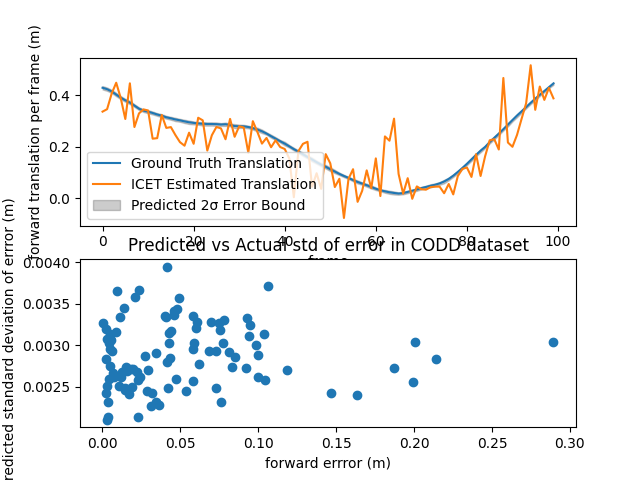

correlation: 
 [[1.         0.05894094]
 [0.05894094 1.        ]]


In [44]:
fig, ax = plt.subplots(2,1)

ax[0].plot(vf, label = 'Ground Truth Translation')

vf = vf[:runlen]

# print(estimates[:,0])
ax[0].plot(estimates[:,1], label = "ICET Estimated Translation")
# ax[0].plot(estimates[:,0] + pred_stds[:,0], color = [0,0,0], alpha = 0.1)
# ax[0].plot(estimates[:,0] - pred_stds[:,0], color = [0,0,0], alpha = 0.1)
ax[0].fill_between(np.linspace(0,runlen-1,runlen), 
                   vf - 2*pred_stds[:,1], vf + 2*pred_stds[:,1], 
                   color = [0,0,0], alpha = 0.2, label = 'Predicted 2σ Error Bound')
ax[0].set_xlabel("frame")
ax[0].set_ylabel("forward translation per frame (m)")
ax[0].legend(loc = 'best')
# ax[0].set_tile("Simple Outlier Rejection")

ferr = vf - estimates[:,1]
# ax[1].plot(abs(ferr))
# ax[1].plot(pred_stds[:,0])
ax[1].scatter(abs(ferr), pred_stds[:,1])
ax[1].set_xlabel("forward errror (m)")
ax[1].set_ylabel("predicted standard deviation of errror (m)")
ax[1].set_title("Predicted vs Actual std of error in CODD dataset")

#correlation between higher predicted std of error and actual higher std of error
print("correlation: \n", np.corrcoef(abs(ferr), pred_stds[:,1]))
# print(np.sum(ferr))
# print(np.sum(vf))

<IPython.core.display.Javascript object>


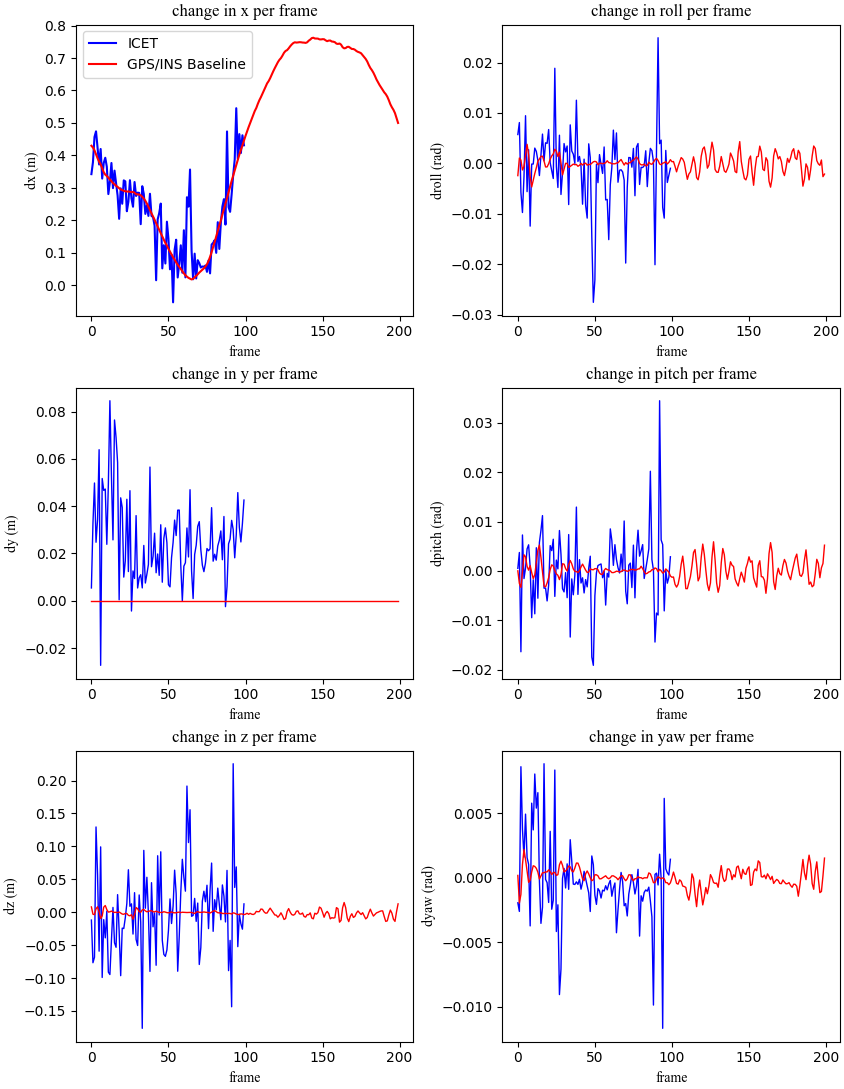

In [45]:
font = {'fontname':'Times New Roman'}
style1 = 'b-'
style2 = 'r-'

fig, ax = plt.subplots(3,2, constrained_layout = True)
ax[0,0].plot(estimates[:,1] + estimates[:,0], style1, label = 'ICET')
ax[0,0].plot(ground_truth[:,1]*.1, style2, label = 'GPS/INS Baseline')
# ax[0,0].plot(np.sqrt(ground_truth[:,0]**2 + ground_truth[:,1]**2), style2, label = 'GPS/INS Baseline')
ax[0,0].set_title("change in x per frame", **font)
ax[0,0].set_ylabel("dx (m)", **font)
ax[0,0].legend(loc = 'upper left')
ax[0,0].set_xlabel("frame", **font)

ax[1,0].plot(estimates[:,0], style1, lw = 1)
ax[1,0].plot(ground_truth[:,0]*.1, style2, lw = 1)
# ax[1,0].plot(np.arange(n//2, np.shape(ICET_estimates)[0] - n//2 ), moving_avg(OXTS_baseline[:,1], n),  style2, lw = 1)
ax[1,0].set_title("change in y per frame", **font)
ax[1,0].set_ylabel("dy (m)", **font)
ax[1,0].set_xlabel("frame", **font)


ax[2,0].plot(estimates[:,2], style1, lw = 1)
ax[2,0].plot(ground_truth[:,2]*.1, style2, lw = 1)
# ax[2,0].plot(np.arange(n//2, np.shape(ICET_estimates)[0] - n//2 ), moving_avg(OXTS_baseline[:,2], n),  style2, lw = 1)
ax[2,0].set_title("change in z per frame", **font)
ax[2,0].set_ylabel("dz (m)", **font)
ax[2,0].set_xlabel("frame", **font)

ax[0,1].plot(estimates[:,3], style1, lw = 1)
ax[0,1].plot(ground_truth[:,3]*.1, style2, lw = 1)
ax[0,1].set_title("change in roll per frame", **font)
ax[0,1].set_ylabel("droll (rad)", **font)
ax[0,1].set_xlabel("frame", **font)


ax[1,1].plot(estimates[:,4], style1, lw = 1)
ax[1,1].plot(ground_truth[:,4]*.1, style2, lw = 1)
ax[1,1].set_title("change in pitch per frame", **font)
ax[1,1].set_ylabel("dpitch (rad)", **font)
ax[1,1].set_xlabel("frame", **font)


ax[2,1].plot(estimates[:,5], style1, lw = 1)
ax[2,1].plot(ground_truth[:,5]*.1, style2, lw = 1)
ax[2,1].set_title("change in yaw per frame", **font)
ax[2,1].set_ylabel("dyaw (rad)", **font)
ax[2,1].set_xlabel("frame", **font)

# fig.tight_layout(h_pad = 0.1)
plt.show()

In [55]:
# print(tf.random.normal([1]).numpy()[0])
test = tf.random.normal([2,3])
print(test + tf.constant([10., 10., 10.]))

tf.Tensor(
[[10.272078 10.116826 10.481981]
 [10.190455  8.892646  8.388034]], shape=(2, 3), dtype=float32)


In [40]:
for i in range(110, 150):
    print(i)

110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
